# <center>Extracting and Analyzing SIOP-Related Tweets</center>
_<center>Leveraging Data Science 2019 SIOP Master Tutorial</center>_



First, let's load the libraries we'll need.

In [5]:
library(rtweet)
library(dplyr)
library(stringr)
library(tm)
library(wordcloud)
library(tidytext)
library(caret)
library(glmnet)


## Accessing Twitter's API
Next we need to set up access to the Twitter API. The Twitter API will allow us to request data from Twitter to use later in our analyses. In order to obtain permission to access the Twitter API, you'll need to first set up credentials. To do this, you'll need to log into Twitter and create an application: https://developer.twitter.com/en/account/get-started. Once you have created an application, locate your "keys and tokens." We'll temporarily save these to our local R environment. Make sure you don't share these with others!

Add your keys here:

In [6]:
# Replace these with your Twitter access keys (in the quote) - DO NOT SHARE YOUR KEYS WITH OTHERS
appname <- "SIOP Data Science Tutorial"
key <- "key"
secret <- "secretkey"
access_token <- "accesstoken"
access_secret <- "secretaccesstoken"
	
# Store these keys for the next step (just run this script)
twitter_token<- create_token(
  app = appname,
  consumer_key = key,
  consumer_secret = secret,
  access_token = access_token,
  access_secret =access_secret)


Now that we have our Twitter API credential set up, we can submit an API request. To do this we will use the R package **rtweet** (https://rtweet.info/). Using this package you can interact with Twitter's API by searching recent tweets by keywords, publishing tweets, getting trends, and even pulling entire timelines. For this demonstration, we'll be searching for tweets related to SIOP and IO psychology by searching for tweets that contain #SIOP, #IOPsych, #IamSIOP, #SIOP19. 

It's important to note that free access to Twitter's API restricts search capabilities to tweets that have occured in the past 6-9 days. Twitter also limits search results to 18,000 tweets every 15 minutes. Paid tiers provide more access and options. 

Using the **rtweets::search_tweets()**  we'll specify our search parameters using the _q_ argument and the number of tweets using the _n_ argument. We'll also save our output to a csv file. 


In [9]:
#This code is commented out because we already have our data. To uncomment, remove the # in front of the code. 

#siop_tweets <- search_tweets(q = "#SIOP OR #IOPsych OR #IamSIOP OR #SIOP19",
#                              n = 1500)
#write_as_csv(siop_tweets, "tweets.csv")

#for this demonstration, we'll just read in our saved tweets (These tweets were collected over the span of two weeks by running the above function once/week)
tweets <- read.csv("tweets.csv")


## Working with Twitter Data - Visualization and Text Analysis
Now we have some data! Let's check it out by clicking on the file in the "Files" tab to your left in the jupyterlab environment. 

This is pretty clean output but we'll still need to do some data cleaning depending on which parts of the data we're interested in. Let's do some exploring. 

The rtweets package has some built in visualization tools. We'll start by plotting a time series of our tweets using the **ts_plot()** function.

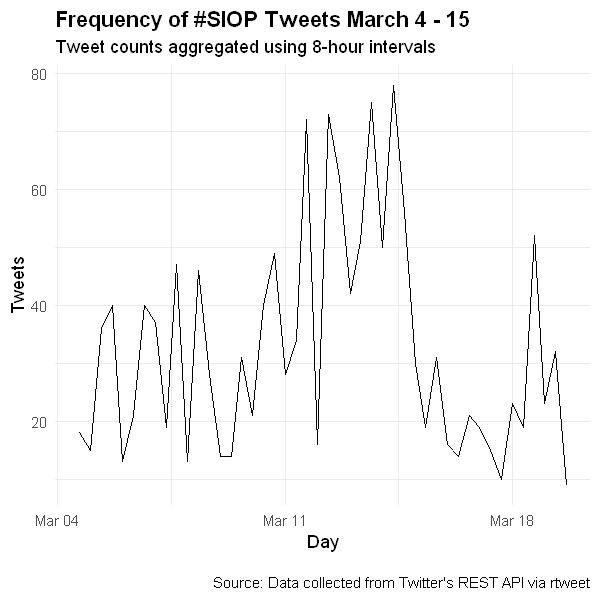

In [10]:
#First Let's specify that the tweet is in English
tweets <- tweets %>%
dplyr::filter(lang == "en")

# Next, let's plot a time series of tweet frequency
options(repr.plot.width=5, repr.plot.height=5) #resize plot

ts_plot(tweets, "8 hours") +
  ggplot2::theme_minimal() +
  ggplot2::theme(plot.title = ggplot2::element_text(face = "bold")) +
  ggplot2::labs(
    x = "Day", y = "Tweets",
    title = "Frequency of #SIOP Tweets March 4 - 15",
    subtitle = "Tweet counts aggregated using 8-hour intervals",
    caption = "\nSource: Data collected from Twitter's REST API via rtweet"
  )

It looks like there was an uptick in tweets sometime between March 12-14.

Now let's start to look at tweet content. This is going to require a bit of text preprocessing.

In [11]:
# Let's first drop retweets since those will provided redundant text. 
tweets_preprocessed <- tweets%>%
dplyr::filter(is_retweet == FALSE)

#make sure that worked (note that only RT without added text are removed so we'll keep the ones with commentary)
table(tweets_preprocessed$is_retweet)



FALSE 
  707 

Here is the twitter text prior to pre-processing (a random sample of the dataset):

In [12]:
tweets_preprocessed %>%
mutate(text = as.character(text))%>%
select(text)%>%
sample_n(size = 10)

,text
675,"#GQRevents is excited to attend SIOP 2019 in Washington, D.C on April 2-6th! Learn more about the conference here &gt;&gt; https://t.co/R9MOVMPqPK #SIOP19 https://t.co/JTMYPRhYJ3"
136,Need a new headshot? Looking for a new linkedin profile picture? Check it out #IOPsych peeps! See you in less than 4 weeks... https://t.co/wKRUwgkhdL
370,A lot of small #iopsych firms possess similarly sensitive datasets and perhaps donâ€™t fully appreciate data security as they should; a cautionary tale for sure in here: â€œHere's What It's Like to Accidentally Expose the Data of 230M Peopleâ€ https://t.co/yq1hSRpn96
403,"RT Talent_metrics ""RT SIOP_ECC: ""SIOP's 2019 Early Career Practitioner Consortium Looks Amazing"" TalyaBauer: https://t.co/Uu1EF8YB94 #IOPsych, #SIOP19 https://t.co/us0EZvfhKv"""
669,A flipped workplace optimizes for productivity and accountability. https://t.co/Hsrj51Ymxy @qz @Allison_Baum #Productivity #IOPsych #CompanyCulture #OrgDev #Workplace
387,"Have any of my Twitter pals published a non-fiction book? I have an idea I've been toying with relating to #iopsych / management, and I'd love to start really exploring the possibility. Not sure how one gets a publisher! https://t.co/iJPlGEue8G"
119,"Almost all apps of #IOpsych (selection, HR Planning, leadership, PA, OD) = measurement against criteria to gauge effectiveness."
229,"exciting #siop19 news: #cherryblossoms are the real deal, folks @sioptweets #iopysch...Cherry blossom forecast: Peak bloom in Washington around April 3 https://t.co/smLaqcjA8B"
237,"Newsworthy or statistical artifact? If @Google controls for all factorsâ€”eg, gender &amp; performanceâ€”then raises pay to match predicted level (but not raising anyoneâ€˜s already above that predicted mean), are they simply eliminating standard error? #iopsych https://t.co/cTFgW6qkVw"
14,Just a few days until the next @ATDNYC People Science SIG event w Dr. Cynthia Hedricks &amp; Dr Disha Rupayana from @SkillSurvey at @IOatBaruch Register for this event here: https://t.co/aNBh1onN8I #IOpsych #datadriven #textanalytics #PeopleAnalytics #HRanalytics https://t.co/xTXsWuaYt9


Now we need to do some preprocessing. We'll remove URLs, retweets, hashtags, mentions, special characters, punctuation, and stopwords. 

We'll also strip white space, and convert to lowercase. 

In [52]:
#preprocess tweet test
tweets_preprocessed$text <- lapply(tweets_preprocessed$text, function(x) {

  x = gsub('http\\S+\\s*', '', x) # Remove URLs
  x = gsub('[[:punct:]]', '', x) # Remove Punctuations
  x =  iconv(x,from="UTF-8",to="ASCII//TRANSLIT") # remove accents
  x = gsub('\\b+RT', '', x) # Remove RT
  x = gsub('#\\S+', '', x) # Remove Hashtags
  x = gsub('@\\S+', '', x) # Remove Mentions
  x = gsub('[[:cntrl:]]', '', x) # Remove Controls and special characters
  x = str_to_lower(x) # convert to lowercase
  x = removeWords(x, stopwords("en")) # remove stopwords
  x = removeWords(x, c("amp", "dont","get", "will","use")) # remove "amp" associated with & and other words that are not meaningful in this context
  x = gsub(' +',' ',x) # Remove extra whitespaces
  
})


Let's re-examine the text after preprocessing. 

In [53]:
tweets_preprocessed %>%
mutate(text = as.character(text))%>%
select(text)%>%
sample_n(size = 10)


,text
372,people look twitter account program place spread awareness faculty graduate students research conference presentations celebrate thesis dissertation milestones like see
76,siops early career practitioner consortium looks amazing
58,shl thread haves variety positions open around globe ranging consulting interested contact referral bonus job winwin
264,excited giving two talks summer psychology change need endtoend process design
580,performance appraisal satisfaction organizational commitment
371,often like see program account tweet month week
158,submit research project award grant apply scholarship funding help expense carrying dissertation research nominate deserving colleague one siopas distinguished awards
317,women thrive economies thrive just post post tweet tweet make difference
358,looking think growing needs io psychology students gain inside classroom look see student org can fill gaps
292,aintersectionala jinglejangle fallacy ainteraction effecta


Now we need to create a corpus and convert our text into a document term matrix (rows are tweets, columns are n-grams)

In [54]:
tweets_corpus <- VCorpus(VectorSource(tweets_preprocessed$text))# Convert to corpus

tweets_dtm <- DocumentTermMatrix(tweets_corpus) #create a document-term-matrix
tweets_dtm <- removeSparseTerms(tweets_dtm, 0.99)# We'll also get rid of relatively unusual terms
DTM_df <- as.data.frame(as.matrix(tweets_dtm)) #finally let's convert the dtm into a dataframe
head(DTM_df)

also,amazing,annual,another,april,around,article,ask,attend,available,...,well,work,working,workplace,workshop,world,worth,year,years,youll
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


Now that our tweet text is clean, let's start to look the text a bit. We can visualize common words with a simple wordcloud.

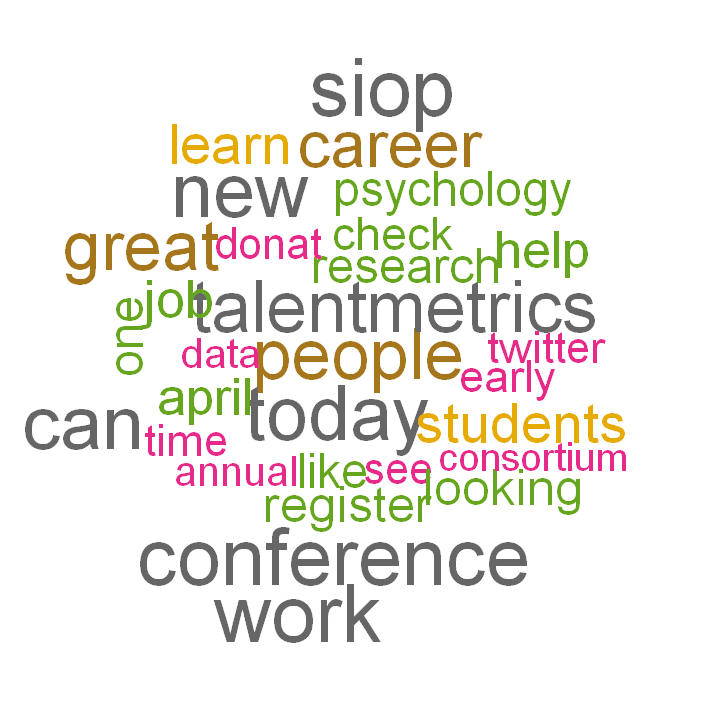

In [55]:
# Create wordcloud
wordCounts <- colSums(DTM_df)
wordNames <- names(DTM_df)
options(repr.plot.width=6, repr.plot.height=6) #resize plot
wordcloud(wordNames, wordCounts, max.words=30,, colors = brewer.pal(8, "Dark2"))

We can also look at the a list of the most frequent words

In [56]:
tibble(wordNames, wordCounts) %>% arrange(desc(wordCounts)) %>% top_n(20)

Selecting by wordCounts


wordNames,wordCounts
siop,52
work,52
conference,51
new,49
today,49
can,48
talentmetrics,46
people,45
great,44
career,41


Let's also analyze the sentiment of tweets and break down word clounds by sentiment. Perhaps we'll see what negative and positive words people are using. 

We'll use the **tidytext** package. Sentiment can be calculated in a number of ways. You can use dictionaries that assign scores to individual words (a really negative word is -5 and a really positive word is 5). You can also label individual words as positive or negative. For this example, we'll score individual words using the bing dictionary which labels words as positive or negative (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html).

Here's what the word dictionary looks like:

In [57]:
tail(get_sentiments("bing"))


word,sentiment
zealous,negative
zealously,negative
zenith,positive
zest,positive
zippy,positive
zombie,negative


In [58]:
#Prepare data for analyzing sentiment
wordlist<-tibble(wordNames, wordCounts) #create a tibble of words and counts
colnames(wordlist)<-c("word","count") #rename columns to match sentiment dictionary
# we'll map on the sentiment labels with an inner_join
# note that using an inner join will only keep words that exist in the sentiment dictionary
sentiment_wordlist<- inner_join(wordlist, get_sentiments("bing"), by = "word") 


You can see the newly classified words:

In [59]:
head(sentiment_wordlist)

word,count,sentiment
amazing,8,positive
available,8,positive
awesome,9,positive
best,18,positive
better,9,positive
cool,8,positive


We can now look at common positive and negative words:

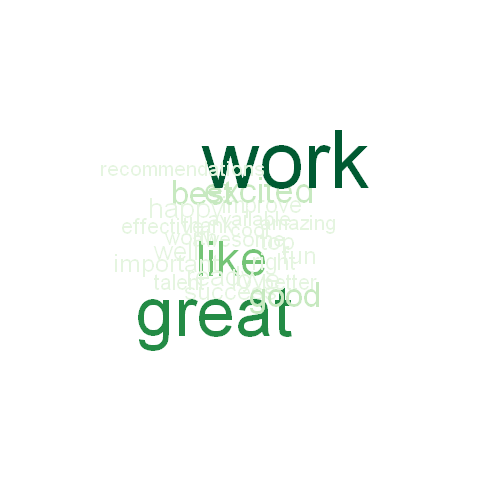

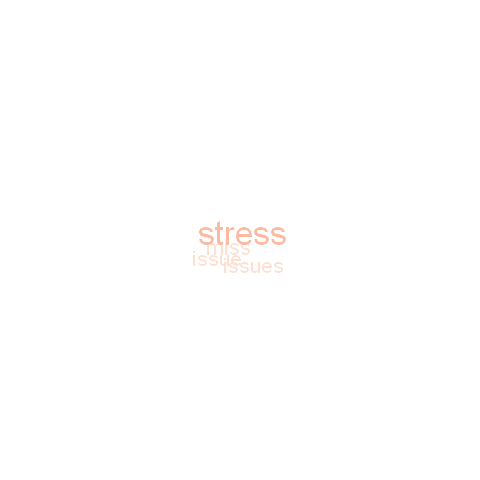

In [60]:
options(repr.plot.width=4, repr.plot.height=4) #resize plot
#par(mfrow=c(2,2)) #plot side by side
#visualize positive words
positivewordlist<- sentiment_wordlist %>%
filter(sentiment == "positive") 
wordcloud(positivewordlist$word, positivewordlist$count, max.words=30,, colors = brewer.pal(8, "Greens"))

#visualize negative words 
negativewordlist<- sentiment_wordlist %>%
filter(sentiment == "negative") 
wordcloud(negativewordlist$word, positivewordlist$count, max.words=30,, colors = brewer.pal(8, "Reds"))

## Predicting Tweet Popularity using Machine Learning
Now say we want to predict retweets and favorite counts by the words used in a tweet.

In [61]:
tweet_popularity <- mutate(tweets_preprocessed, tweet_popularity = favorite_count + retweet_count) %>%
select(tweet_popularity)

model_data <- cbind(DTM_df, tweet_popularity)

#add in tweet ID number
model_data$ID <- seq.int(nrow(model_data))

#move ID and tweet popularity to front of dataset 
model_data <- select(model_data, ID, tweet_popularity, everything())
head(model_data)


ID,tweet_popularity,also,amazing,annual,another,april,around,article,ask,...,well,work,working,workplace,workshop,world,worth,year,years,youll
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
#set seed for reproducibility
set.seed(167)

# let's create a holdout dataset
index <- createDataPartition(model_data$ID, p=0.80, list=FALSE)
training_df <- model_data[index,]
test_df <- model_data[-index,]
# let's set up vectors of algorithms to look at
algo_vec <- c("glmnet")

# create Kfold index
index <- createFolds(training_df$ID, k=5)
training_df<-training_df[-1] #remove id var
test_df<-test_df[-1] # remove id var


# iterate through analyses and create each model, also validate versus test set
results_df <- data_frame(model=as.character(), validity=as.numeric())
models <- list()
for (j in 1:length(algo_vec)) {
    resultName <- paste0("JP","-",algo_vec[j])
    garbage<-capture.output( #supress output
    models[[resultName]] <- train(  
      tweet_popularity ~ .,
      tuneLength=5,
      data=training_df,
      method=algo_vec[j],
      preProcess=c("zv", "corr"),
      trControl=trainControl(method="cv", number=5, verboseIter=T, index=index)
    )
        )
    results_df <- bind_rows(results_df, data_frame(
      model=resultName,
      validity=cor(predict(models[[resultName]], test_df), pull(test_df, tweet_popularity))
    )
    )
  }


#examine results
results_df

#examine top 20 vars/model
lapply(models, varImp)

model,validity
JP-glmnet,0.1596877


$`JP-glmnet`
glmnet variable importance

  only 20 most important variables shown (out of 203)

              Overall
even           100.00
working         97.26
employee        76.11
article         63.37
iam             63.34
show            62.41
evidence        59.44
around          40.40
ready           36.91
best            35.05
research        34.80
people          33.87
important       30.30
donat           27.14
learning        22.05
students        19.86
study           18.17
talentmetrics   18.11
life            16.70
know            15.66
